In [1]:
import sentencepiece as sp

In [3]:
import os

''' Concatenate the contents of all files in the data folder into one single text file named full.txt. '''
def concat_files():
    with open('full.txt', 'w', encoding='utf8') as f:
        for file in os.listdir('data'):
            with open(os.path.join('data', file), encoding='utf8') as g:
                f.write(g.read())

concat_files()

In [ ]:
sp.SentencePieceTrainer.train(input='full.txt', model_prefix='m_en_de', vocab_size=15000, model_type='unigram', character_coverage=1.0, input_sentence_size=10000000, shuffle_input_sentence=True, max_sentence_length=1000, num_threads=16, unk_id=0, bos_id=1, eos_id=2, pad_id=3)

In [1]:
import torch
import numpy as np

c:\Users\Chen Zerui\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.tril(np.ones(attn_shape)).astype('uint8')
    return torch.from_numpy(subsequent_mask)

In [3]:
subsequent_mask(10)

tensor([[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]], dtype=torch.uint8)

In [55]:
class FibonacciDataset(torch.utils.data.Dataset):
    
	''' A toy dataset that generates pairs of fibonaci sequences starting at a random float between -1 and 1.
	The second sequence is the first sequence shifted by one position to the right.
	 '''

	def __init__(self, block_size=16):
		super().__init__()
		self.block_size = block_size

	def __getitem__(self, idx):
		start = np.random.uniform(-1, 1)
		fib = [start, start]
		for i in range(self.block_size - 1):
			fib.append(fib[-1] + fib[-2])
		x = torch.tensor(fib[:-1], dtype=torch.float32)
		y = torch.tensor(fib[1:], dtype=torch.float32)
		return x, y
	
	def __len__(self):
		return 10000000000000

FibonacciDataset()[0]

(tensor([  -0.9382,   -0.9382,   -1.8765,   -2.8147,   -4.6912,   -7.5059,
          -12.1971,  -19.7030,  -31.9001,  -51.6031,  -83.5033, -135.1064,
         -218.6097, -353.7161, -572.3258, -926.0419]),
 tensor([-9.3824e-01, -1.8765e+00, -2.8147e+00, -4.6912e+00, -7.5059e+00,
         -1.2197e+01, -1.9703e+01, -3.1900e+01, -5.1603e+01, -8.3503e+01,
         -1.3511e+02, -2.1861e+02, -3.5372e+02, -5.7233e+02, -9.2604e+02,
         -1.4984e+03]))

In [94]:
class ReversionDataset(torch.utils.data.Dataset):
	
	''' A toy dataset that generates pairs of sequences, where the second sequence is the first sequence reversed.
	 '''

	def __init__(self, block_size=16):
		super().__init__()
		self.block_size = block_size

	def __getitem__(self, idx):
		x = torch.randint(0, 10, (self.block_size,), dtype=torch.float32)
		y = x.flip(0)
		return x, y
	
	def __len__(self):
		return 10000000000000

In [91]:
from torch import nn, Tensor
import torch.nn.functional as F

class InputEmbeddings(nn.Module):
	''' Apply learnable token and position embeddings to input tokens. '''

	def __init__(self, vocab_size: int, emb_dim: int, block_size: int):
		super().__init__()
		self.token_embedding_table = nn.Embedding(vocab_size, emb_dim)
		self.position_embedding_table = nn.Embedding(block_size, emb_dim)
		self.register_buffer('pos_emb_index', torch.arange(block_size))
	
	def forward(self, x: Tensor):
		B, T = x.shape
		tok_embd = self.token_embedding_table(x)
		pos_embd = self.position_embedding_table(self.pos_emb_index[:T])
		return tok_embd + pos_embd

class MultiHeadSelfAttention(nn.Module):

	''' Multi-head self attention.
	Implements a somewhat optimized version of the self attention by combining the q, k, v projections.
	
	Inputs:
		x: input tensor of shape (B, T, C)
		mask: mask tensor of shape broadcastable to (B, T, T)
	'''

	def __init__(self, n_heads: int, emb_dim: int, bias: bool, block_size: int, is_causal: bool = False):
		super().__init__()
		self.is_causal = is_causal
		self.n_heads = n_heads
		self.emb_dim = emb_dim
		# combine q, k, v projections for efficiency
		self.qkv_projection = nn.Linear(emb_dim, 3 * emb_dim, bias=bias)
		self.register_buffer('scale', torch.tensor(emb_dim ** -0.5, dtype=torch.float32))
		if is_causal:
			self.register_buffer('causal_mask', torch.tril(torch.ones(1, block_size, block_size, dtype=torch.bool)))

	def forward(self, x: Tensor, mask: Tensor, return_attentions: bool = False):
		B, T, C = x.shape
		# proj q, k, v for all heads
		# the heads are treated as a batch dimension
		q, k, v = self.qkv_projection(x).split(self.emb_dim, dim=2)
		q = q.view(B, T, self.n_heads, C // self.n_heads).transpose(1, 2)
		k = k.view(B, T, self.n_heads, C // self.n_heads).transpose(1, 2)
		v = v.view(B, T, self.n_heads, C // self.n_heads).transpose(1, 2)
		# compute attention
		att_weights = (q @ k.transpose(-2, -1)) / self.scale
		mask = mask.unsqueeze(1) # apply mask over all heads
		if self.is_causal:
			mask = mask & self.causal_mask[:, :T, :T]
		att_weights = att_weights.masked_fill(mask == 0, -1e9)
		att_weights = F.softmax(att_weights, dim=-1)
		y = att_weights @ v
		# combine heads
		y = y.transpose(1, 2).contiguous().view(B, T, C)
		if return_attentions:
			return y, att_weights, v
		return y

class MultiHeadCrossAttention(nn.Module):

	''' Multi-head cross attention.
	Implements a somewhat optimized version of the cross attention by combining the k, v projections.
	
	Inputs:
		x_q: query tensor of shape (B, T, C)
		x_kv: key and value tensor of shape (B, T, C)
		mask: mask tensor of shape broadcastable to (B, T, T)
	'''

	def __init__(self, n_heads: int, emb_dim: int, bias: bool):
		super().__init__()
		self.n_heads = n_heads
		self.emb_dim = emb_dim
		self.q_projection = nn.Linear(emb_dim, emb_dim, bias=bias)
		# combine k, v projections for efficiency
		self.kv_projection = nn.Linear(emb_dim, 2 * emb_dim, bias=bias)
		self.register_buffer('scale', torch.tensor(emb_dim ** -0.5, dtype=torch.float32))

	def forward(self, x_q: Tensor, x_kv: Tensor, mask: Tensor):
		# proj query for all heads
		B, T, C = x_q.shape
		q = self.q_projection(x_q)
		q = q.view(B, T, self.n_heads, C // self.n_heads).transpose(1, 2)
		# proj key & value for all heads
		B, T, C = x_kv.shape
		k, v = self.kv_projection(x_kv).split(self.emb_dim, dim=2)
		k = k.view(B, T, self.n_heads, C // self.n_heads).transpose(1, 2)
		v = v.view(B, T, self.n_heads, C // self.n_heads).transpose(1, 2)
		# compute attention
		att_weights = (q @ k.transpose(-2, -1)) / self.scale
		mask = mask.unsqueeze(1) # apply mask over all heads
		att_weights = att_weights.masked_fill(mask == 0, -1e9)
		att_weights = F.softmax(att_weights, dim=-1)
		y = att_weights @ v
		# combine heads
		y = y.transpose(1, 2).contiguous().view(B, T, C)
		return y

class FeedFoward(nn.Module):

	def __init__(self, emb_dim: int, dropout: float = 0.0):
		super().__init__()
		self.net = nn.Sequential(
			nn.Linear(emb_dim, 4 * emb_dim),
			nn.ReLU(),
			nn.Linear(4 * emb_dim, emb_dim),
		)
		if dropout:
			self.net.append(nn.Dropout(dropout))

	def forward(self, x: Tensor):
		return self.net(x)
	
class LMHead(nn.Module):

	def __init__(self, emb_dim: int, vocab_size: int):
		super().__init__()
		self.ln = nn.LayerNorm(emb_dim)
		self.logits_head = nn.Linear(emb_dim, vocab_size)
	
	def forward(self, x: Tensor):
		x = self.ln(x)
		x = self.logits_head(x)
		return x

In [104]:
from tqdm import tqdm

# train a single multi-head attention layer on the reversion dataset, using mse loss and adamw optimizer
n_steps = 10000
batch_size = 128
block_size = 128
n_heads = 1
emb_dim = 1
lr = 1e-2

mha = MultiHeadSelfAttention(n_heads, emb_dim, False, block_size, False).cuda()

# init ds & dl
ds = ReversionDataset(block_size)
dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=False)

# init optim
optimizer = torch.optim.AdamW(mha.parameters(), lr=lr)

# training loop, using tqdm and showing loss at every step
pbar = tqdm(dl, total=n_steps)
i = 0
for x, y in pbar:
	if i > n_steps:
		break
	x = x.unsqueeze(-1).cuda()
	x_mask = torch.ones(block_size).cuda()
	y = y.unsqueeze(-1).cuda()
	pred = mha(x, x_mask)
	loss = F.mse_loss(pred, y)
	loss.backward()
	optimizer.step()
	optimizer.zero_grad()
	pbar.set_description(f'loss: {loss.item():.3f}')

loss: 8.176:  45%|████▌     | 4512/10000 [00:18<00:22, 243.47it/s]


KeyboardInterrupt: 

In [113]:
from tqdm import tqdm

# train a single multi-head attention layer on the reversion dataset, using mse loss and adamw optimizer
n_steps = 10000
batch_size = 128
block_size = 128
n_heads = 1
emb_dim = 1
lr = 1e-2

mha = torch.nn.MultiheadAttention(emb_dim, n_heads, dropout=0.0, bias=False, batch_first=True).cuda()

# init ds & dl
ds = ReversionDataset(block_size)
dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=False)

# init optim
optimizer = torch.optim.AdamW(mha.parameters(), lr=lr)

# training loop, using tqdm and showing loss at every step
pbar = tqdm(dl, total=n_steps)
i = 0
for x, y in pbar:
	if i > n_steps:
		break
	x = x.unsqueeze(-1).cuda()
	x_mask = torch.ones(block_size).cuda()
	y = y.unsqueeze(-1).cuda()
	pred, atten_weights = mha(x, x, x)
	loss = F.mse_loss(pred, y)
	loss.backward()
	optimizer.step()
	optimizer.zero_grad()
	pbar.set_description(f'loss: {loss.item():.3f}')

loss: 8.178:  44%|████▍     | 4383/10000 [00:19<00:25, 224.20it/s]


KeyboardInterrupt: 

In [118]:
# test the mha layer on the fibonacci dataset
ds = FibonacciDataset(16)
x, y = ds[0]
x = x.unsqueeze(0).unsqueeze(-1).cuda()
x_mask = torch.ones(x.shape[1], dtype=torch.long).cuda()
y_pred, attn, v = mha(x, x_mask, return_attentions=True)
print('x\t', *x.view(16).cpu().numpy())
print('y\t', *y.view(16).numpy())
print('y_pred\t', *y_pred.detach().view(16).cpu().numpy())
print('v\t', *v.detach().view(16).cpu().numpy())

x	 -0.5083462 -0.5083462 -1.0166924 -1.5250385 -2.5417309 -4.0667696 -6.6085005 -10.67527 -17.28377 -27.95904 -45.24281 -73.20185 -118.44466 -191.64651 -310.09116 -501.73767
y	 -0.5083462 -1.0166924 -1.5250385 -2.5417309 -4.0667696 -6.6085005 -10.67527 -17.28377 -27.95904 -45.24281 -73.20185 -118.44466 -191.64651 -310.09116 -501.73767 -811.82886
y_pred	 -0.8225174 -0.8225174 -1.1174242 -1.5367235 -2.546073 -5.310747 -10.554775 -17.272297 -27.96559 -45.238453 -73.20404 -118.4425 -191.64653 -310.08905 -501.73557 -811.8246
v	 -0.8225174 -0.8225174 -1.6450348 -2.467552 -4.1125865 -6.580139 -10.692726 -17.272865 -27.96559 -45.238453 -73.20404 -118.4425 -191.64653 -310.08905 -501.73557 -811.8246


<Axes: >

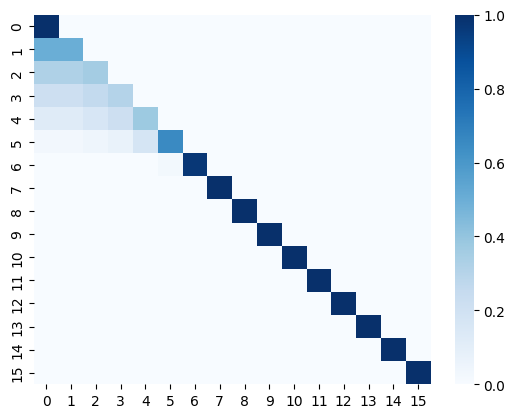

In [119]:
# plot the attention weights as heatmap, using seaborn
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(attn[0, 0].detach().cpu().numpy(), cmap='Blues')

In [114]:
from tqdm import tqdm

n_steps = 10000
batch_size = 128
mha = MultiHeadSelfAttention(1, 1, False, 16, True).cuda()

# train a single mha layer on the fibonacci dataset for n_steps, using mse loss and adamw optimizer
ds = FibonacciDataset(16)
dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=False)
optimizer = torch.optim.AdamW(mha.parameters(), lr=5e-3)

pbar = tqdm(dl, total=n_steps)
i = 0
for x, y in pbar:
	if i > n_steps:
		break
	x = x.unsqueeze(-1).cuda()
	x_mask = subsequent_mask(x.shape[1]).cuda()
	y = y.unsqueeze(-1).cuda()
	pred = mha(x, x_mask)
	loss = F.mse_loss(pred, y)
	loss.backward()
	optimizer.step()
	optimizer.zero_grad()
	pbar.set_description(f'loss: {loss.item():.3f}')
	i += 1

loss: 0.405: : 10001it [00:47, 212.63it/s]                            


In [124]:
mha.qkv_projection.weight.detach().cpu()

tensor([[-4.2840],
        [-0.0503],
        [ 1.6180]])

In [82]:
-4.7116 * -3.5511

16.73136276